In [1]:
# Load packages
import HSMM_LtR as hsmm
from training import hsmm_model

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import norm
import numpy as np
import pickle as pk
import random
from sklearn.model_selection import train_test_split

from operator import methodcaller
from tqdm.notebook import tqdm
import pandas as pd

import os

In [2]:
### Load 0 data ###
with open('X_train_rate_0.pk', 'rb') as f:
    X_train_0 = pk.load(f)

with open('y_train_rate_0.pk', 'rb') as f:
    y_train_0 = pk.load(f)
    
with open('stratify_train_rate_0.pk', 'rb') as f:
    stratify_train_0 = pk.load(f)

with open('X_test_rate_0.pk', 'rb') as f:
    X_test_0 = pk.load(f)

with open('y_test_rate_0.pk', 'rb') as f:
    y_test_0 = pk.load(f)
    
with open('stratify_test_rate_0.pk', 'rb') as f:
    stratify_test_0 = pk.load(f)

### Load 1 data ###
with open('X_train_rate_1.pk', 'rb') as f:
    X_train_1 = pk.load(f)

with open('y_train_rate_1.pk', 'rb') as f:
    y_train_1 = pk.load(f)
    
with open('stratify_train_rate_1.pk', 'rb') as f:
    stratify_train_1 = pk.load(f)

with open('X_test_rate_1.pk', 'rb') as f:
    X_test_1 = pk.load(f)

with open('y_test_rate_1.pk', 'rb') as f:
    y_test_1 = pk.load(f)
    
with open('stratify_test_rate_1.pk', 'rb') as f:
    stratify_test_1 = pk.load(f)

In [3]:
### Indices split ### 
def split_indices(x_length, num_splits = 10):
    chunk_size = int(x_length/num_splits)
    
    indices = [1]
    
    for i in range(num_splits):
        if i < (num_splits -1):
            indices.append(chunk_size*(i+1))
    indices.append(x_length)
    
    return indices

In [4]:
### Load Trained Models ###
model_list_0 = []
model_fnames_0 = ['model_train_N3_nc_0.pk','model_train_N5_nc_0.pk',
               'model_train_N7_nc_0.pk','model_train_N9_nc_0.pk']

for model_name in model_fnames_0:
    with open(model_name, 'rb') as f:
        model = pk.load(f)
        model_list_0.append(model)
        
model_list_1 = []
model_fnames_1 = ['model_train_N3_nc_1.pk','model_train_N5_nc_1.pk',
               'model_train_N7_nc_1.pk','model_train_N9_nc_1.pk','model_train_N13_nc_1.pk']

for model_name in model_fnames_1:
    with open(model_name, 'rb') as f:
        model = pk.load(f)
        model_list_1.append(model)

In [5]:
def create_pred_df(model, x, y, stratify):
    pbar = tqdm()
    pbar.reset(total=len(x))  
    
    df = []
    column_names = ['PID','ts_num','gap','prediction','lower','upper','target','x']
    counter = {}
    
    for x_i, y_i, s_i in zip(x,y,stratify):
        # Get PID and gap
        pid = s_i.split('_')
        gap = pid[1]
        pid = pid[0]
        
        if pid in counter:
            counter[pid] += 1
        else:
            counter[pid] = 1
        
        # Generate indices
        end = x_i.shape[0] - 39
        
        indices = split_indices(end)
        for i in indices:
            mid, lower, upper, target = model.predict(x_i[:i+1], y=y_i)
            mid= np.clip(mid,0,None)
            lower=np.clip(lower,0,None)
            upper=np.clip(upper,0,None)
            target=np.clip(target,0,None)
            
            row = [pid, counter[pid], gap, mid, lower, upper, target, x_i[i]]
            
            df.append(row)
        
        pbar.update()

    return pd.DataFrame(df, columns=column_names)

In [122]:
'''
x_train_0_new = []
y_train_0_new = []
stratify_train_0_new = []

x_train_1_new = []
y_train_1_new = []
stratify_train_1_new = []

x_test_0_new = []
y_test_0_new = []
stratify_test_0_new = []

x_test_1_new = []
y_test_1_new = []
stratify_test_1_new = []

## TODO: Move data from 1 to 0 and 0 to 1 depending on if head moves before or after TOT
for i,x_i in enumerate(X_train_0):
    if (np.sum(x_i[:-39] >= .35) >= 2):
        x_train_1_new.append(x_i)
        y_train_1_new.append(y_train_0[i])
        stratify_train_1_new.append(stratify_train_0[i])
    else:
        x_train_0_new.append(x_i)
        y_train_0_new.append(y_train_0[i])
        stratify_train_0_new.append(stratify_train_0[i])
    
for i,x_i in enumerate(X_train_1):
    if (np.sum(x_i[:-39] <= .3)/x_i[:-40].shape[0]) >= 0.99:
        x_train_0_new.append(x_i)
        y_train_0_new.append(y_train_1[i])
        stratify_train_0_new.append(stratify_train_1[i])
    else:
        x_train_1_new.append(x_i)
        y_train_1_new.append(y_train_1[i])
        stratify_train_1_new.append(stratify_train_1[i])

for i,x_i in enumerate(X_test_0):
    if (np.sum(x_i[:-39] >= .35) >= 2):
        x_test_1_new.append(x_i)
        y_test_1_new.append(y_test_0[i])
        stratify_test_1_new.append(stratify_test_0[i])
    else:
        x_test_0_new.append(x_i)
        y_test_0_new.append(y_test_0[i])
        stratify_test_0_new.append(stratify_test_0[i])

for i,x_i in enumerate(X_test_1):
    if (np.sum(x_i[:-39] <= .3)/x_i[:-40].shape[0]) >= 0.99:
        x_test_0_new.append(x_i)
        y_test_0_new.append(y_test_1[i])
        stratify_test_0_new.append(stratify_test_1[i])
    else:
        x_test_1_new.append(x_i)
        y_test_1_new.append(y_test_1[i])
        stratify_test_1_new.append(stratify_test_1[i])


## TODO: Move data from 1 to 0 and 0 to 1 depending on if head moves before or after TOT

pdf = PdfPages("train_output_0.pdf")

for i,x_i in enumerate(x_train_0_new):
    fig = plt.figure()
    ax = sns.lineplot(x=np.arange(x_i[:-40].shape[0]), y=x_i[:-40], sort=False, markers=True, dashes=False)
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(str(i))
    pdf.savefig( fig )
    plt.close()

pdf.close()        

pdf = PdfPages("train_output_1.pdf")

for i,x_i in enumerate(x_train_1_new):
    fig = plt.figure()
    ax = sns.lineplot(x=np.arange(x_i[:-40].shape[0]), y=x_i[:-40], sort=False, markers=True, dashes=False)
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(str(i))
    pdf.savefig( fig )
    plt.close()

pdf.close() 
        
pdf = PdfPages("test_output_0.pdf")

for i,x_i in enumerate(x_test_0_new):
    fig = plt.figure()
    ax = sns.lineplot(x=np.arange(x_i[:-40].shape[0]), y=x_i[:-40], sort=False, markers=True, dashes=False)
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(str(i))
    pdf.savefig( fig )
    plt.close()

pdf.close()

pdf = PdfPages("test_output_1.pdf")

for i,x_i in enumerate(x_test_1_new):
    fig = plt.figure()
    ax = sns.lineplot(x=np.arange(x_i[:-40].shape[0]), y=x_i[:-40], sort=False, markers=True, dashes=False)
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(str(i))
    pdf.savefig( fig )
    plt.close()
    
pdf.close()

### Load 0 data ###
with open('X_train_rate_0.pk', 'wb') as f:
    pk.dump(x_train_0_new,f)

with open('y_train_rate_0.pk', 'wb') as f:
    pk.dump(y_train_0_new,f)
    
with open('stratify_train_rate_0.pk', 'wb') as f:
    pk.dump(stratify_train_0_new,f)

with open('X_test_rate_0.pk', 'wb') as f:
    pk.dump(x_test_0_new,f)

with open('y_test_rate_0.pk', 'wb') as f:
    pk.dump(y_test_0_new,f)
    
with open('stratify_test_rate_0.pk', 'wb') as f:
    pk.dump(stratify_test_0_new,f)

### Load 1 data ###
with open('X_train_rate_1.pk', 'wb') as f:
    pk.dump(x_train_1_new, f)

with open('y_train_rate_1.pk', 'wb') as f:
    pk.dump(y_train_1_new, f)
    
with open('stratify_train_rate_1.pk', 'wb') as f:
    pk.dump(stratify_train_1_new, f)

with open('X_test_rate_1.pk', 'wb') as f:
    pk.dump(x_test_1_new, f)

with open('y_test_rate_1.pk', 'wb') as f:
    pk.dump(y_test_1_new, f)
    
with open('stratify_test_rate_1.pk', 'wb') as f:
    pk.dump(stratify_test_1_new, f)
'''

# Plotting Training Loss

In [136]:
model_train_loss_0 = []
model_test_loss_0 = []

for i in model_list_0:
    df_preds_0 = create_pred_df(i, X_train_0, y_train_0, stratify_train_0)
    training_results_0 = (df_preds_0['target'] - df_preds_0['prediction'])
    df_preds_0 = create_pred_df(i, X_test_0, y_test_0, stratify_test_0)
    test_results_0 = (df_preds_0['target'] - df_preds_0['prediction'])
    model_train_loss_0.append(training_results_0.abs().mean())
    model_test_loss_0.append(test_results_0.abs().mean())

(0, 0.7467923726699689)

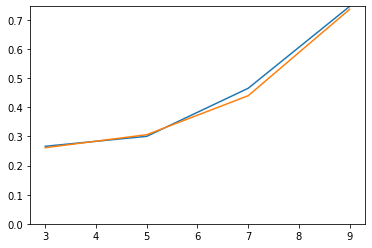

In [138]:
fig = plt.figure()
ax = sns.lineplot(x=[3,5,7,9], y=model_train_loss_0, sort=False)
ax = sns.lineplot(x=[3,5,7,9], y=model_test_loss_0, sort=False)
ax.set_ylim(0,max(model_train_loss_0))

# Offline Model Performance

In [195]:
model_train_loss_1 = []
model_test_loss_1 = []

for i in model_list_1:
    df_preds_1 = create_pred_df(i, X_train_1, y_train_1, stratify_train_1)
    training_results_1 = (df_preds_1['target'] - df_preds_1['prediction'])
    df_preds_1 = create_pred_df(i, X_test_1, y_test_1, stratify_test_1)
    test_results_1 = (df_preds_1['target'] - df_preds_1['prediction'])
    model_train_loss_1.append(training_results_1.abs().mean())
    model_test_loss_1.append(test_results_1.abs().mean())

(0, 0.7113243517323731)

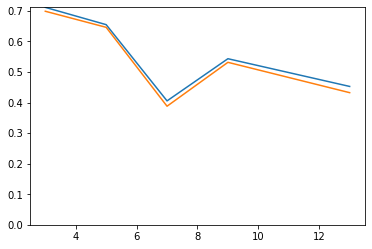

In [196]:
fig = plt.figure()
ax = sns.lineplot(x=[3,5,7,9,13], y=model_train_loss_1, sort=False)
ax = sns.lineplot(x=[3,5,7,9,13], y=model_test_loss_1, sort=False)
ax.set_ylim(0,max(model_train_loss_1))

# Offline Model Performance

# Offline Model Performance

## Head pose to road after deactivation

In [42]:
model_offline_0 = model_list_0[0]

In [68]:
df_offline_train_0 = create_pred_df(model_offline_0, X_train_0, y_train_0, stratify_train_0)

In [69]:
results_offline = (df_offline_train_0['target'] - df_offline_train_0['prediction'])
print(results_offline.abs().mean(), results_offline.abs().std())

0.23933542925836007 0.20427725465321386


In [70]:
df_offline_test_0 = create_pred_df(model_offline_0, X_test_0, y_test_0, stratify_test_0)

In [71]:
results_offline_test = (df_offline_test_0['target'] - df_offline_test_0['prediction'])
print(results_offline_test.abs().mean(), results_offline_test.abs().std())

0.23079901019476476 0.1954250288947913


In [61]:
pdf = PdfPages("pred_results_offline_0.pdf")

counter = 0

for pid in df_offline_test_0['PID'].unique():
    df_pid = df_offline_test_0.loc[df_offline_test_0['PID'] == pid]
    for ts_index in df_pid['ts_num'].unique():
        fig = plt.figure()
        ax = sns.lineplot(x='target', y='prediction', data = df_pid.loc[df_pid['ts_num'] == ts_index], sort=False, markers=True, dashes=False)
        ax.set_xlim(df_pid.loc[df_pid['ts_num'] == ts_index]['target'].max(), 0)
        ax.set_ylim(bottom=0)
        ax.set_title(str(pid) + str(ts_index))
        
        ax = sns.lineplot(x='target', y='x', data = df_pid.loc[df_pid['ts_num'] == ts_index], sort=False, markers=True, dashes=False)
        
        pdf.savefig( fig )
        plt.close()
        
        counter += 1

pdf.close()

## Head pose to road before deactivation

In [12]:
model_offline_1 = model_list_1[1]

In [13]:
df_offline_train_1 = create_pred_df(model_offline_1, X_train_1, y_train_1, stratify_train_1)

In [14]:
results_offline = (df_offline_train_1['target'] - df_offline_train_1['prediction'])
print(results_offline.abs().mean(), results_offline.abs().std())

0.3882715179441476 0.3617707724973076


In [15]:
df_offline_test_1 = create_pred_df(model_offline_1, X_test_1, y_test_1, stratify_test_1)

In [16]:
results_offline_test = (df_offline_test_1['target'] - df_offline_test_1['prediction'])
print(results_offline_test.abs().mean(), results_offline_test.abs().std())

0.36032045192645057 0.35224756653663


In [17]:
pdf = PdfPages("pred_results_offline_1.pdf")

counter = 0

for pid in df_offline_test_1['PID'].unique():
    df_pid = df_offline_test_1.loc[df_offline_test_1['PID'] == pid]
    for ts_index in df_pid['ts_num'].unique():
        fig = plt.figure()
        ax = sns.lineplot(x='target', y='prediction', data = df_pid.loc[df_pid['ts_num'] == ts_index], sort=False, markers=True, dashes=False)
        ax.set_xlim(df_pid.loc[df_pid['ts_num'] == ts_index]['target'].max(), 0)
        ax.set_ylim(bottom=0)
        ax.set_title(str(pid) + str(ts_index))
        
        ax = sns.lineplot(x='target', y='x', data = df_pid.loc[df_pid['ts_num'] == ts_index], sort=False, markers=True, dashes=False)
        
        pdf.savefig( fig )
        plt.close()
        
        counter += 1

pdf.close()

# Online Models

In [301]:
with open('X_train_rate.pk', 'rb') as f:
    X_train = pk.load(f)

with open('y_train_rate.pk', 'rb') as f:
    y_train = pk.load(f)
    
with open('stratify_train_rate.pk', 'rb') as f:
    stratify_train = pk.load(f)

with open('X_test_rate.pk', 'rb') as f:
    X_test = pk.load(f)

with open('y_test_rate.pk', 'rb') as f:
    y_test = pk.load(f)
    
with open('stratify_test_rate.pk', 'rb') as f:
    stratify_test = pk.load(f)

In [302]:
pid_range = ['PID01','PID02','PID03','PID04','PID05',
                'PID06','PID07','PID08','PID09','PID10',
                'PID11','PID12','PID13','PID14','PID15',
                'PID16','PID17','PID18','PID19','PID20',
                'PID21','PID22','PID23','PID24','PID25',
                'PID26','PID27','PID28','PID29','PID30',
                'PID31','PID32','PID33','PID34']

In [303]:
pid_train_list = []
gap_train_list = []
for i in stratify_train:
    pid_train_list.append(i.split('_')[0])
    gap_train_list.append(i.split('_')[1])
    
pid_test_list = []
gap_test_list = []
for i in stratify_test:
    pid_test_list.append(i.split('_')[0])
    gap_test_list.append(i.split('_')[1])

In [373]:
df_online_train_list = []
df_online_test_list = []

for pid_i in pid_range:
    with open(os.path.join('models','online', pid_i + '_1.pk'), 'rb') as f:
        model_online = pk.load(f)
    
    # Train
    X_online = [X_train[j] for j,d in enumerate(pid_train_list) if d == pid_i]
    y_online = [y_train[j] for j,d in enumerate(pid_train_list) if d == pid_i]
    stratify_online = [stratify_train[j] for j,d in enumerate(pid_train_list) if d == pid_i]
    
    df_online_train_list.append(create_pred_df(model_online, X_online, y_online, stratify_online))
    
    # Test
    X_online = [X_test[j] for j,d in enumerate(pid_test_list) if d == pid_i]
    y_online = [y_test[j] for j,d in enumerate(pid_test_list) if d == pid_i]
    stratify_online = [stratify_test[j] for j,d in enumerate(pid_test_list) if d == pid_i]
    
    df_online_test_list.append(create_pred_df(model_online, X_online, y_online, stratify_online))
    

In [43]:
df_offline_train = pd.concat([df_offline_train_0, df_offline_train_1])
df_offline_test = pd.concat([df_offline_test_0, df_offline_test_1])

NameError: name 'df_offline_train_0' is not defined

In [375]:
column_names = ['PID','train mae offline','train se offline','train mae online','train se online',
               'test mae offline','test se offline','test mae online','test se online']
df_compare = []
for i,pid_i in enumerate(pid_range):
    row = [pid_i]
    
    # Train
    df_temp = df_offline_train[df_offline_train['PID'] == pid_i]
    results_temp = (df_temp['target'] - df_temp['prediction'])
    
    row.append(results_temp.abs().mean())
    row.append(results_temp.abs().std())
    
    results_temp = (df_online_train_list[i]['target'] - df_online_train_list[i]['prediction'])
    
    row.append(results_temp.abs().mean())
    row.append(results_temp.abs().std())

    # Test
    df_temp = df_offline_test[df_offline_test['PID'] == pid_i]
    results_temp = (df_temp['target'] - df_temp['prediction'])
    
    row.append(results_temp.abs().mean())
    row.append(results_temp.abs().std())
    
    results_temp = (df_online_test_list[i]['target'] - df_online_test_list[i]['prediction'])
    
    row.append(results_temp.abs().mean())
    row.append(results_temp.abs().std())
    
    df_compare.append(row)

In [376]:
# Create the pandas DataFrame 
df_compare = pd.DataFrame(df_compare, columns = column_names) 

In [377]:
print((df_compare['train mae offline'] - df_compare['train mae online']).mean())
print((df_compare['test mae offline'] - df_compare['test mae online']).mean())

-0.08334169826359546
-0.08940339436175629


# Other Models

## Create Data Features

In [18]:
# Load packages
import HSMM_LtR as hsmm
from training import hsmm_model

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import norm
import numpy as np
import pickle as pk
import random
from sklearn.model_selection import train_test_split

from operator import methodcaller
from tqdm.notebook import tqdm
import pandas as pd

import os

In [19]:
# Looad Data
with open('X_train_rate_other.pk', 'rb') as f:
    X_train_om = pk.load(f)

with open('y_train_rate_other.pk', 'rb') as f:
    y_train_om = pk.load(f)
    
with open('stratify_train_rate_other.pk', 'rb') as f:
    stratify_train_om = pk.load(f)

with open('X_test_rate_other.pk', 'rb') as f:
    X_test_om = pk.load(f)

with open('y_test_rate_other.pk', 'rb') as f:
    y_test_om = pk.load(f)
    
with open('stratify_test_rate_other.pk', 'rb') as f:
    stratify_test_om = pk.load(f)

In [20]:
# Load Data 1
with open('X_train_rate_other_0.pk', 'rb') as f:
    X_train_om_0 = pk.load(f)

with open('y_train_rate_other_0.pk', 'rb') as f:
    y_train_om_0 = pk.load(f)
    
with open('stratify_train_rate_other_0.pk', 'rb') as f:
    stratify_train_om_0 = pk.load(f)

with open('X_test_rate_other_0.pk', 'rb') as f:
    X_test_om_0 = pk.load(f)

with open('y_test_rate_other_0.pk', 'rb') as f:
    y_test_om_0 = pk.load(f)
    
with open('stratify_test_rate_other_0.pk', 'rb') as f:
    stratify_test_om_0 = pk.load(f)
    
# Load Data 0
with open('X_train_rate_other_1.pk', 'rb') as f:
    X_train_om_1 = pk.load(f)

with open('y_train_rate_other_1.pk', 'rb') as f:
    y_train_om_1 = pk.load(f)
    
with open('stratify_train_rate_other_1.pk', 'rb') as f:
    stratify_train_om_1 = pk.load(f)

with open('X_test_rate_other_1.pk', 'rb') as f:
    X_test_om_1 = pk.load(f)

with open('y_test_rate_other_1.pk', 'rb') as f:
    y_test_om_1 = pk.load(f)
    
with open('stratify_test_rate_other_1.pk', 'rb') as f:
    stratify_test_om_1 = pk.load(f)

In [21]:
# Create Lags single dataset
# Step 1: Create an empty array
X_train_numpy = np.zeros((len(X_train_om)*11,20))
y_train_numpy = np.zeros((len(X_train_om)*11))

current_row = 0
# Step 2: Assign values by slicing
for x_i, y_i in zip(X_train_om, y_train_om):
    # Iterate through indices
    end = x_i.shape[0] - 70
    index_list = split_indices(end, num_splits = 10)
    for i in index_list:
        end = 20 + i
        start = end - 20
        X_train_numpy[current_row,:] = x_i[start:end]
        y_train_numpy[current_row] = y_i - i/20.0
        current_row += 1
        
X_test_numpy = np.zeros((len(X_test_om)*11,20))
y_test_numpy = np.zeros((len(X_test_om)*11))

current_row = 0
# Step 2: Assign values by slicing
for x_i, y_i in zip(X_test_om, y_test_om):
    # Iterate through indices
    end = x_i.shape[0] - 70
    index_list = split_indices(end, num_splits = 10)
    for i in index_list:
        end = 20 + i
        start = end - 20
        X_test_numpy[current_row,:] = x_i[start:end]
        y_test_numpy[current_row] = y_i - i/20.0
        current_row += 1

In [22]:
# Create Lags split dataset
# Step 1: Create an empty array
X_train_numpy_0 = np.zeros((len(X_train_om_0)*11,20))
y_train_numpy_0 = np.zeros((len(X_train_om_0)*11))

X_train_numpy_1 = np.zeros((len(X_train_om_1)*11,20))
y_train_numpy_1 = np.zeros((len(X_train_om_1)*11))

X_test_numpy_0 = np.zeros((len(X_test_om_0)*11,20))
y_test_numpy_0 = np.zeros((len(X_test_om_0)*11))

X_test_numpy_1 = np.zeros((len(X_test_om_1)*11,20))
y_test_numpy_1 = np.zeros((len(X_test_om_1)*11))

current_row = 0
# Step 2: Assign values by slicing
for x_i, y_i in zip(X_train_om_0, y_train_om_0):
    # Iterate through indices
    end = x_i.shape[0] - 70
    index_list = split_indices(end, num_splits = 10)
    for i in index_list:
        end = 20 + i
        start = end - 20
        X_train_numpy_0[current_row,:] = x_i[start:end]
        y_train_numpy_0[current_row] = y_i - i/20.0
        current_row += 1
        


current_row = 0
# Step 2: Assign values by slicing
for x_i, y_i in zip(X_test_om_0, y_test_om_0):
    # Iterate through indices
    end = x_i.shape[0] - 70
    index_list = split_indices(end, num_splits = 10)
    for i in index_list:
        end = 20 + i
        start = end - 20
        X_test_numpy_0[current_row,:] = x_i[start:end]
        y_test_numpy_0[current_row] = y_i - i/20.0
        current_row += 1
        
current_row = 0
# Step 2: Assign values by slicing
for x_i, y_i in zip(X_train_om_1, y_train_om_1):
    # Iterate through indices
    end = x_i.shape[0] - 70
    index_list = split_indices(end, num_splits = 10)
    for i in index_list:
        end = 20 + i
        start = end - 20
        X_train_numpy_1[current_row,:] = x_i[start:end]
        y_train_numpy_1[current_row] = y_i - i/20.0
        current_row += 1

current_row = 0
# Step 2: Assign values by slicing
for x_i, y_i in zip(X_test_om_1, y_test_om_1):
    # Iterate through indices
    end = x_i.shape[0] - 70
    index_list = split_indices(end, num_splits = 10)
    for i in index_list:
        end = 20 + i
        start = end - 20
        X_test_numpy_1[current_row,:] = x_i[start:end]
        y_test_numpy_1[current_row] = y_i - i/20.0
        current_row += 1

## Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
reg = LinearRegression().fit(X_train_numpy, y_train_numpy)
reg_0 = LinearRegression().fit(X_train_numpy_0, y_train_numpy_0)
reg_1 = LinearRegression().fit(X_train_numpy_1, y_train_numpy_1)

In [25]:
print(np.mean(np.abs(reg.predict(X_train_numpy)-y_train_numpy)))
print(np.mean(np.concatenate((np.abs(reg_0.predict(X_train_numpy_0)-y_train_numpy_0),np.abs(reg_1.predict(X_train_numpy_1)-y_train_numpy_1)))))

0.35369316893881125
0.3345031230808526


In [26]:
print(np.mean(np.abs(reg.predict(X_test_numpy)-y_test_numpy)))
print(np.mean(np.concatenate((np.abs(reg_0.predict(X_test_numpy_0)-y_test_numpy_0),np.abs(reg_1.predict(X_test_numpy_1)-y_test_numpy_1)))))
print(np.std(np.concatenate((np.abs(reg_0.predict(X_test_numpy_0)-y_test_numpy_0),np.abs(reg_1.predict(X_test_numpy_1)-y_test_numpy_1)))))

0.3412611330412251
0.31241323451496195
0.25430185579743675


## Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train_numpy, y_train_numpy)

regr_0 = RandomForestRegressor(max_depth=2, random_state=0)
regr_0.fit(X_train_numpy_0, y_train_numpy_0)

regr_1 = RandomForestRegressor(max_depth=2, random_state=0)
regr_1.fit(X_train_numpy_1, y_train_numpy_1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [29]:
print(np.mean(np.abs(regr.predict(X_train_numpy)-y_train_numpy)))
print(np.mean(np.concatenate((np.abs(regr_0.predict(X_train_numpy_0)-y_train_numpy_0),np.abs(regr_1.predict(X_train_numpy_1)-y_train_numpy_1)))))


0.33969871601326884
0.31718960481391306


In [30]:
print(np.mean(np.abs(regr.predict(X_test_numpy)-y_test_numpy)))
rf_test_results = np.concatenate((np.abs(regr_0.predict(X_test_numpy_0)-y_test_numpy_0),np.abs(regr_1.predict(X_test_numpy_1)-y_test_numpy_1)))
print(np.mean(rf_test_results), np.std(rf_test_results))


0.32674090125905086
0.3064220247877915 0.24215273960143302


## XGBoost

In [107]:
import xgboost as xgb

In [108]:
xgbr = xgb.XGBRegressor(max_depth=6) 
xgbr.fit(X_train_numpy, y_train_numpy)

xgbr_0 = xgb.XGBRegressor(max_depth=6) 
xgbr_0.fit(X_train_numpy_0, y_train_numpy_0)

xgbr_1 = xgb.XGBRegressor(max_depth=6) 
xgbr_1.fit(X_train_numpy_1, y_train_numpy_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [109]:
print(np.mean(np.abs(xgbr.predict(X_train_numpy)-y_train_numpy)))
print(np.mean(np.abs(xgbr_0.predict(X_train_numpy_0)-y_train_numpy_0)))
print(np.mean(np.abs(xgbr_1.predict(X_train_numpy_1)-y_train_numpy_1)))

0.07546477762128416
0.02669211577343065
0.02180854871322474


In [110]:
print(np.mean(np.abs(xgbr.predict(X_test_numpy)-y_test_numpy)))
test_xgbr_results = np.concatenate((np.abs(xgbr_0.predict(X_test_numpy_0)-y_test_numpy_0),np.abs(xgbr_1.predict(X_test_numpy_1)-y_test_numpy_1)))
print(np.mean(test_xgbr_results), np.std(test_xgbr_results))

0.3169533693917932
0.2826062994815024 0.24688323395416065


In [111]:
xgbr_pred_0 = xgbr_0.predict(X_test_numpy_0)
xgbr_pred_1 = xgbr_1.predict(X_test_numpy_1)


In [112]:
pdf = PdfPages("pred_results_offline_xgboost_0.pdf")

for i in range(int(y_test_numpy_0.shape[0]/11)):
    fig = plt.figure()
    
    ax = sns.lineplot(x=y_test_numpy_0[i*11:(i+1)*11], y=xgbr_pred_0[i*11:(i+1)*11], sort=False)
    ax.set_xlim(np.max(y_test_numpy_0[i*11:(i+1)*11]), 0)
    ax.set_title(i)
    pdf.savefig( fig )
    plt.close()
             
pdf.close()

In [113]:
pdf = PdfPages("pred_results_offline_xgboost_1.pdf")

for i in range(int(y_test_numpy_1.shape[0]/11)):
    fig = plt.figure()
    
    ax = sns.lineplot(x=y_test_numpy_1[i*11:(i+1)*11], y=xgbr_pred_1[i*11:(i+1)*11], sort=False)
    ax.set_xlim(np.max(y_test_numpy_1[i*11:(i+1)*11]), 0)
    ax.set_title(i)
    pdf.savefig( fig )
    plt.close()
             
pdf.close()

In [73]:
df_offline_test = pd.concat([df_offline_test_0, df_offline_test_1])


In [156]:
df_hsmm_test = (df_offline_test['target']-df_offline_test['prediction']).abs()
print(df_hsmm_test.mean(), df_hsmm_test.std())

0.2688935518805543 0.25855321591726427


### Compare HSMM vs XGBoost

In [75]:
y = np.concatenate((df_hsmm_test.values, test_xgbr_results))
x = np.concatenate((np.repeat(np.arange(11),df_hsmm_test.shape[0]/11),np.repeat(np.arange(11), test_xgbr_results.shape[0]/11)))
hue = ['HSMM'] * df_hsmm_test.shape[0] + ['XGBoost'] * test_xgbr_results.shape[0]

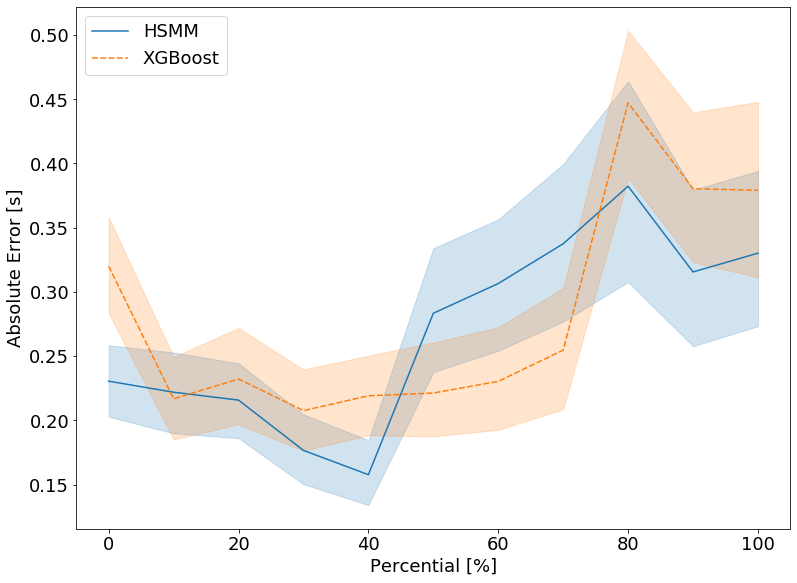

In [76]:
fig = plt.figure(figsize=[12.8, 9.6])
ax = sns.lineplot(x=x, y=y, hue=hue, style=hue ,sort=False)

plt.xlabel('Percential [%]', fontsize=18)
plt.ylabel('Absolute Error [s]', fontsize=18)

ax.set_xticklabels([-20,0,20,40,60,80,100,120], fontdict={'fontsize':18})
ax.set_yticklabels(["%.2f" % i for i in np.around(ax.get_yticks(), decimals=2)], fontdict={'fontsize':18})

plt.legend(loc='upper left', fontsize=18)

# Split Data

In [8]:
'''
x_train_0_new = []
y_train_0_new = []
stratify_train_0_new = []

x_train_1_new = []
y_train_1_new = []
stratify_train_1_new = []

x_test_0_new = []
y_test_0_new = []
stratify_test_0_new = []

x_test_1_new = []
y_test_1_new = []
stratify_test_1_new = []

## TODO: Move data from 1 to 0 and 0 to 1 depending on if head moves before or after TOT
for i,x_i in enumerate(X_train_om):
    if (np.sum(x_i[20:-39] >= .35) >= 2):
        x_train_1_new.append(x_i)
        y_train_1_new.append(y_train_om[i])
        stratify_train_1_new.append(stratify_train_om[i])
    else:
        x_train_0_new.append(x_i)
        y_train_0_new.append(y_train_om[i])
        stratify_train_0_new.append(stratify_train_om[i])

for i,x_i in enumerate(X_test_om):
    if (np.sum(x_i[20:-39] >= .35) >= 2):
        x_test_1_new.append(x_i)
        y_test_1_new.append(y_test_om[i])
        stratify_test_1_new.append(stratify_test_om[i])
    else:
        x_test_0_new.append(x_i)
        y_test_0_new.append(y_test_om[i])
        stratify_test_0_new.append(stratify_test_om[i])


### Load 0 data ###
with open('X_train_rate_other_0.pk', 'wb') as f:
    pk.dump(x_train_0_new,f)

with open('y_train_rate_other_0.pk', 'wb') as f:
    pk.dump(y_train_0_new,f)
    
with open('stratify_train_rate_other_0.pk', 'wb') as f:
    pk.dump(stratify_train_0_new,f)

with open('X_test_rate_other_0.pk', 'wb') as f:
    pk.dump(x_test_0_new,f)

with open('y_test_rate_other_0.pk', 'wb') as f:
    pk.dump(y_test_0_new,f)
    
with open('stratify_test_rate_other_0.pk', 'wb') as f:
    pk.dump(stratify_test_0_new,f)

### Load 1 data ###
with open('X_train_rate_other_1.pk', 'wb') as f:
    pk.dump(x_train_1_new, f)

with open('y_train_rate_other_1.pk', 'wb') as f:
    pk.dump(y_train_1_new, f)
    
with open('stratify_train_rate_other_1.pk', 'wb') as f:
    pk.dump(stratify_train_1_new, f)

with open('X_test_rate_other_1.pk', 'wb') as f:
    pk.dump(x_test_1_new, f)

with open('y_test_rate_other_1.pk', 'wb') as f:
    pk.dump(y_test_1_new, f)
    
with open('stratify_test_rate_other_1.pk', 'wb') as f:
    pk.dump(stratify_test_1_new, f)
'''

# Plots

## XGBoost and HSMM time series examples

In [152]:
# XGBoost 1 = index 20, HSMM 1 = PID14 TS2
# XGBoost 0 = index 2, HSMM 0 = index 6

ts_1_1 = df_offline_test_1[np.all([df_offline_test_1['PID']=='PID14', df_offline_test_1['ts_num']==2], axis=0)]
ts_1_2 =xgbr_pred_1[20*11:21*11]
ts_2_1 = df_offline_test_0[np.all([df_offline_test_0['PID']=='PID14', df_offline_test_0['ts_num']==2], axis=0)]
ts_2_2 = xgbr_pred_0[13*11:14*11]

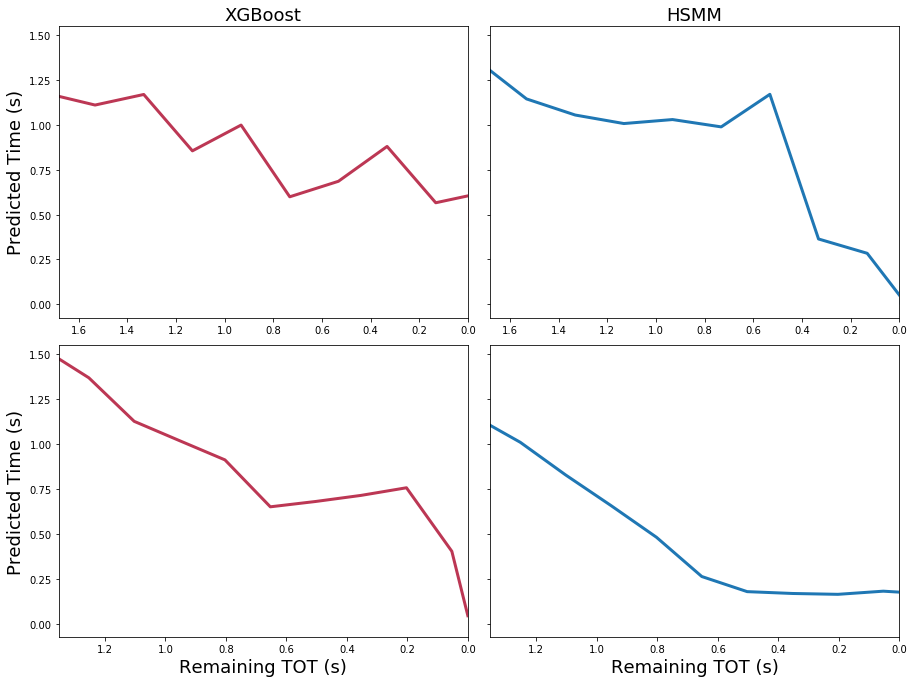

In [153]:
import matplotlib.ticker as plticker
f, ax = plt.subplots(2, 2, sharey=True, figsize = [12.8, 9.6])
loc = plticker.MultipleLocator(base=0.25)
ts_1_1 = df_offline_test_1[np.all([df_offline_test_1['PID']=='PID08', df_offline_test_1['ts_num']==1], axis=0)]

sns.lineplot(x=ts_1_1['target'].values, y=xgbr_pred_1[13*11:14*11], size=[1]*11, sizes=(3,3), hue=['red']*11, palette='inferno', ax=ax[0,0])
ax[0,0].set_xlim(np.max(ts_1_1['target'].values), 0)
ax[0,0].get_legend().remove()
ax[0,0].yaxis.set_major_locator(loc)

sns.lineplot(x=ts_1_1['target'].values, y=ts_1_1['prediction'].values, size=[1]*11, sizes=(3,3), ax=ax[0,1])
ax[0,1].set_xlim(np.max(ts_1_1['target'].values), 0)
ax[0,1].get_legend().remove()

ts_2_2 = xgbr_pred_0[7*11:8*11]
ts_2_1 = df_offline_test_0[np.all([df_offline_test_0['PID']=='PID34', df_offline_test_0['ts_num']==2], axis=0)]

sns.lineplot(x=ts_2_1['target'].values, y=ts_2_2, size=[1]*11, sizes=(3,3), hue=['red']*11, palette='inferno',ax=ax[1,0])
ax[1,0].set_xlim(np.max(ts_2_1['target'].values), 0)
ax[1,0].get_legend().remove()

sns.lineplot(x=ts_2_1['target'].values, y=ts_2_1['prediction'].values, size=[1]*11, sizes=(3,3), ax=ax[1,1])
ax[1,1].set_xlim(np.max(ts_2_1['target'].values), 0)
ax[1,1].get_legend().remove()

ax[0,0].set_ylabel('Predicted Time (s)', fontsize=18)
ax[0,0].set_title('XGBoost', fontsize=18)
ax[1,0].set_ylabel('Predicted Time (s)', fontsize=18)
ax[0,1].set_title('HSMM', fontsize=18)

ax[1,0].set_xlabel('Remaining TOT (s)', fontsize=18)
ax[1,1].set_xlabel('Remaining TOT (s)', fontsize=18)

plt.tight_layout()
plt.show()

In [155]:
ts_2_1['target'].values

array([1.353, 1.253, 1.103, 0.953, 0.803, 0.653, 0.503, 0.353, 0.203,
       0.053, 0.   ])